# Rekomendasi Unsupervised Lbl2vec

In [1]:
from google_play_scraper import app
from google_play_scraper import Sort, reviews
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lbl2vec import Lbl2Vec
from gensim.utils import simple_preprocess
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import strip_tags
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tqdm import tqdm

tqdm.pandas()

In [ ]:
result, continuation_token = reviews(
    'com.dafturn.mypertamina',
    lang='id', 
    country='id', 
    sort=Sort.MOST_RELEVANT, 
    count=114904, 
    filter_score_with=None
)

In [7]:
df = pd.DataFrame.from_dict(result)
df = df[['userName', 'score','at', 'content']]

In [2]:
import re
def cleaningulasan(ulasan):
  ulasan = re.sub(r'@[A-Za-a0-9]+',' ',ulasan)
  ulasan = re.sub(r'#[A-Za-z0-9]+',' ',ulasan)
  ulasan = re.sub(r"http\S+",' ',ulasan)
  ulasan = re.sub(r'[0-9]+',' ',ulasan)
  ulasan = re.sub(r"[-()\"#/@;:<>{}'+=~|.!?,_]", " ", ulasan)
  ulasan = ulasan.strip(' ')
  return ulasan

def clearEmoji(ulasan):
    return ulasan.encode('ascii', 'ignore').decode('ascii')

def replaceTOM(ulasan):
    pola = re.compile(r'(.)\1{2,}', re.DOTALL)
    return pola.sub(r'\1', ulasan)

def casefoldingText(ulasan):
  ulasan = ulasan.lower()
  return ulasan

In [9]:
df['Cleaning']= df['content'].apply(cleaningulasan)
df['HapusEmoji']= df['Cleaning'].apply(clearEmoji)
df['3/Lebih']= df['HapusEmoji'].apply(replaceTOM)
df['CaseFolding']= df['3/Lebih'].apply(casefoldingText)

In [10]:
def convertToSlangword(ulasan):
    kamusSlang = eval(open("NLP_bahasa_resources\combined_slang_words.txt").read())
    content = []
    for kata in ulasan.split():
        try:
            content.append(kamusSlang[kata])
        except:
            content.append(kata)
    ulasan = ' '.join(content)
    return ulasan

df['Formalisasi'] = df['CaseFolding'].apply(convertToSlangword)

In [2]:
df = pd.read_csv('review_mobile_jkn_processed.csv')

In [21]:
positive = pd.read_csv('InSet\positive.tsv', sep='\t', index_col='word')
negative = pd.read_csv('InSet\\negative.tsv', sep='\t', index_col='word')

# inset = pd.concat([positive, negative]).to_dict()['weight']
positive = positive.to_dict()['weight']
negative = negative.to_dict()['weight']

In [22]:
def sentiment_score(ulasan):
    inset_positive_score = 0
    inset_negative_score = 0

    for kata in str(ulasan).split():
        try:
            inset_positive_score += positive[kata]
        except:
            inset_positive_score += 0
        
        try:
            inset_negative_score += negative[kata]
        except:
            inset_negative_score += 0

    return inset_positive_score + inset_negative_score

df['sentiment_score'] = df['CaseFolding'].progress_apply(sentiment_score)

100%|██████████| 114904/114904 [00:02<00:00, 44064.64it/s] 


In [4]:
df = df[['userName', 'score','at', 'content', 'Formalisasi', 'sentiment_score']]
df

,userName,score,at,content,Formalisasi,sentiment_score
0,Setiawan Jodi,1,2022-10-03 05:19:36,Saat login kode capchta tidak muncul jaringan ...,saat login kode capchta tidak muncul jaringan ...,-23
1,Sri Astuti,1,2022-09-27 04:34:32,"Aplikasi yg gak jelas, hal yg mudah dibuat jd ...",aplikasi yang gak jelas hal yang mudah dibuat ...,0
2,Pratiwi R,2,2022-10-03 07:16:04,Aplikasi nya kurang bagus versi sekarang... Ma...,aplikasi nya kurang bagus versi sekarang mau l...,-10
3,adnan maulana,5,2022-10-03 00:47:33,"Kekurangannya, tidak seluruh Bank tersedia unt...",kekurangannya tidak seluruh bank tersedia untu...,12
4,Indria Mandala Putri,1,2022-10-03 09:50:28,Di satu sisi aplikasi ini bagus dan memudahkan...,di satu sisi aplikasi ini bagus dan memudahkan...,-17
...,...,...,...,...,...,...
124592,Pengguna Google,5,2016-10-28 11:48:57,Ok,ok,4
124593,Suprapto Rtku,5,2022-06-08 04:17:08,Setiyasih Setiyasih,setiyasih setiyasih,0
124594,Pengguna Google,5,2016-07-29 14:12:34,Good,good,5
124595,Pengguna Google,5,2016-10-27 12:12:42,Good,good,5


## Value Count by Score

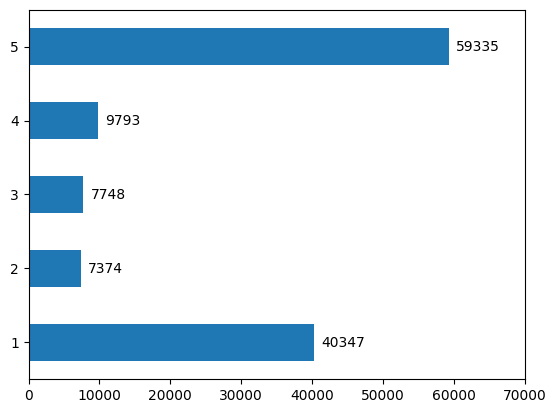

In [45]:
ax = df['score'].value_counts().sort_index().plot(kind='barh')
ax.bar_label(ax.containers[0], padding=5)
ax.set_xlim(right=70000)

plt.show()

In [24]:
# df.to_csv('review_mypertamina.csv', index=False)

In [25]:
# df = pd.read_csv('review_mypertamina.csv')

In [5]:
labels = pd.read_csv('label_keyword_jkn (1).csv',sep=';')
labels['keywords'] = labels['keywords'].apply(lambda x: x.lower().split(' '))
labels['number_of_keywords'] = labels['keywords'].apply(lambda row: len(row))

In [23]:
labels

,class_index,class_name,keywords,number_of_keywords
0,1,user_experience,"[ribet, menyulitkan, mempermudah, mudah, kuran...",26
1,2,server,"[server, time, out, loading, gangguan]",5
2,3,payment,"[bank, bayar, pembayaran, auto, debit, autodeb...",9
3,5,authentication_and_account,"[edit, profile, password, login, email, masuk,...",24
4,7,faskes,"[faskes, pribadi, kartu, bpjs]",4


In [5]:
def tokenize(doc):
    return simple_preprocess(strip_tags(doc), deacc=True, min_len=2, max_len=15)

In [33]:
df.head()

,userName,score,at,content,Formalisasi,sentiment_score,tagged_docs,doc_key
0,Setiawan Jodi,1,2022-10-03 05:19:36,Saat login kode capchta tidak muncul jaringan ...,saat login kode capchta tidak muncul jaringan ...,-23,"([saat, login, kode, capchta, tidak, muncul, j...",0
1,Sri Astuti,1,2022-09-27 04:34:32,"Aplikasi yg gak jelas, hal yg mudah dibuat jd ...",aplikasi yang gak jelas hal yang mudah dibuat ...,0,"([aplikasi, yang, gak, jelas, hal, yang, mudah...",1
2,Pratiwi R,2,2022-10-03 07:16:04,Aplikasi nya kurang bagus versi sekarang... Ma...,aplikasi nya kurang bagus versi sekarang mau l...,-10,"([aplikasi, nya, kurang, bagus, versi, sekaran...",2
3,adnan maulana,5,2022-10-03 00:47:33,"Kekurangannya, tidak seluruh Bank tersedia unt...",kekurangannya tidak seluruh bank tersedia untu...,12,"([kekurangannya, tidak, seluruh, bank, tersedi...",3
4,Indria Mandala Putri,1,2022-10-03 09:50:28,Di satu sisi aplikasi ini bagus dan memudahkan...,di satu sisi aplikasi ini bagus dan memudahkan...,-17,"([di, satu, sisi, aplikasi, ini, bagus, dan, m...",4


In [34]:
# sum(df['Formalisasi'].isna())

In [6]:
df['Formalisasi'] = df['Formalisasi'].fillna('').astype(str)
df['tagged_docs'] = df.progress_apply(lambda row: TaggedDocument(tokenize(row['Formalisasi']), [str(row.name)]), axis=1)

100%|██████████| 124597/124597 [00:10<00:00, 11432.89it/s]


In [9]:
df.head()

,userName,score,at,content,Cleaning,HapusEmoji,3/Lebih,CaseFolding,Formalisasi,sentiment_score,tagged_docs
0,Setiawan Jodi,1,2022-10-03 05:19:36,Saat login kode capchta tidak muncul jaringan ...,Saat login kode capchta tidak muncul jaringan ...,Saat login kode capchta tidak muncul jaringan ...,Saat login kode capchta tidak muncul jaringan ...,saat login kode capchta tidak muncul jaringan ...,saat login kode capchta tidak muncul jaringan ...,-23,"([saat, login, kode, capchta, tidak, muncul, j..."
1,Sri Astuti,1,2022-09-27 04:34:32,"Aplikasi yg gak jelas, hal yg mudah dibuat jd ...",Aplikasi yg gak jelas hal yg mudah dibuat jd ...,Aplikasi yg gak jelas hal yg mudah dibuat jd ...,Aplikasi yg gak jelas hal yg mudah dibuat jd ...,aplikasi yg gak jelas hal yg mudah dibuat jd ...,aplikasi yang gak jelas hal yang mudah dibuat ...,0,"([aplikasi, yang, gak, jelas, hal, yang, mudah..."
2,Pratiwi R,2,2022-10-03 07:16:04,Aplikasi nya kurang bagus versi sekarang... Ma...,Aplikasi nya kurang bagus versi sekarang Ma...,Aplikasi nya kurang bagus versi sekarang Ma...,Aplikasi nya kurang bagus versi sekarang Mau l...,aplikasi nya kurang bagus versi sekarang mau l...,aplikasi nya kurang bagus versi sekarang mau l...,-10,"([aplikasi, nya, kurang, bagus, versi, sekaran..."
3,adnan maulana,5,2022-10-03 00:47:33,"Kekurangannya, tidak seluruh Bank tersedia unt...",Kekurangannya tidak seluruh Bank tersedia unt...,Kekurangannya tidak seluruh Bank tersedia unt...,Kekurangannya tidak seluruh Bank tersedia unt...,kekurangannya tidak seluruh bank tersedia unt...,kekurangannya tidak seluruh bank tersedia untu...,12,"([kekurangannya, tidak, seluruh, bank, tersedi..."
4,Indria Mandala Putri,1,2022-10-03 09:50:28,Di satu sisi aplikasi ini bagus dan memudahkan...,Di satu sisi aplikasi ini bagus dan memudahkan...,Di satu sisi aplikasi ini bagus dan memudahkan...,Di satu sisi aplikasi ini bagus dan memudahkan...,di satu sisi aplikasi ini bagus dan memudahkan...,di satu sisi aplikasi ini bagus dan memudahkan...,-17,"([di, satu, sisi, aplikasi, ini, bagus, dan, m..."


In [7]:
df['doc_key'] = df.index.astype(str)

In [27]:
class EpochLogger(CallbackAny2Vec):
    '''Callback to log information about training'''

    def __init__(self):
        self.epoch = 1

    def on_epoch_begin(self, model):
        print("Epoch #{} start".format(self.epoch))

    def on_epoch_end(self, model):
        print("Epoch #{} end".format(self.epoch))
        self.epoch += 1

epoch_logger = EpochLogger()

doc2vec_model = Doc2Vec(documents=df['tagged_docs'], dbow_words=1, dm=1, alpha=0.001, vector_size=300 ,epochs=100, callbacks=[epoch_logger])

Epoch #1 start
Epoch #1 end
Epoch #2 start
Epoch #2 end
Epoch #3 start
Epoch #3 end
Epoch #4 start
Epoch #4 end
Epoch #5 start
Epoch #5 end
Epoch #6 start
Epoch #6 end
Epoch #7 start
Epoch #7 end
Epoch #8 start
Epoch #8 end
Epoch #9 start
Epoch #9 end
Epoch #10 start
Epoch #10 end
Epoch #11 start
Epoch #11 end
Epoch #12 start
Epoch #12 end
Epoch #13 start
Epoch #13 end
Epoch #14 start
Epoch #14 end
Epoch #15 start
Epoch #15 end
Epoch #16 start
Epoch #16 end
Epoch #17 start
Epoch #17 end
Epoch #18 start
Epoch #18 end
Epoch #19 start
Epoch #19 end
Epoch #20 start
Epoch #20 end
Epoch #21 start
Epoch #21 end
Epoch #22 start
Epoch #22 end
Epoch #23 start
Epoch #23 end
Epoch #24 start
Epoch #24 end
Epoch #25 start
Epoch #25 end
Epoch #26 start
Epoch #26 end
Epoch #27 start
Epoch #27 end
Epoch #28 start
Epoch #28 end
Epoch #29 start
Epoch #29 end
Epoch #30 start
Epoch #30 end
Epoch #31 start
Epoch #31 end
Epoch #32 start
Epoch #32 end
Epoch #33 start
Epoch #33 end
Epoch #34 start
Epoch #34 en

In [10]:
doc2vec_model = Doc2Vec.load('doc2vec_mobileJKN_model')

In [35]:
doc2vec_model.save('doc2vec_mobileJKN_model')

In [123]:
Lbl2Vec_model = Lbl2Vec(keywords_list=list(labels.keywords),  doc2vec_model=doc2vec_model, label_names=list(labels.class_name), similarity_threshold=0.70, min_count=100, min_num_docs=170, epochs=100, clean_outlier=False)

Lbl2Vec_model.fit()

2022-10-20 11:43:12,131 - Lbl2Vec - INFO - Load document and word embeddings
2022-10-20 11:43:12,134 - Lbl2Vec - INFO - Train label embeddings


In [124]:
model_docs_lbl_similarities = Lbl2Vec_model.predict_model_docs()

2022-10-20 11:43:14,951 - Lbl2Vec - INFO - Get document embeddings from model
2022-10-20 11:43:15,114 - Lbl2Vec - INFO - Calculate document<->label similarities


In [125]:
model_docs_lbl_similarities = model_docs_lbl_similarities.merge(df, left_on='doc_key', right_on='doc_key')#[['content','most_similar_label']]

In [126]:
model_docs_lbl_similarities[['content', 'most_similar_label']]

,content,most_similar_label
0,Saat login kode capchta tidak muncul jaringan ...,authentication_and_account
1,"Aplikasi yg gak jelas, hal yg mudah dibuat jd ...",authentication_and_account
2,Aplikasi nya kurang bagus versi sekarang... Ma...,authentication_and_account
3,"Kekurangannya, tidak seluruh Bank tersedia unt...",faskes
4,Di satu sisi aplikasi ini bagus dan memudahkan...,server
...,...,...
124592,Ok,user_experience
124593,Setiyasih Setiyasih,payment
124594,Good,server
124595,Good,server


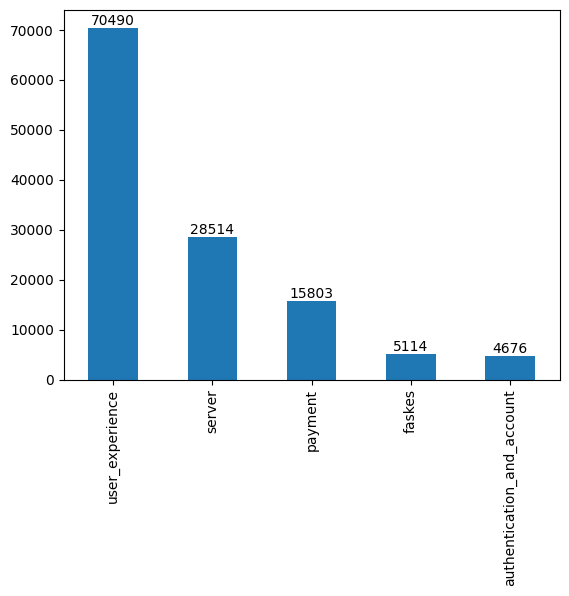

In [127]:
ax = model_docs_lbl_similarities['most_similar_label'].value_counts().plot(kind='bar')
ax.bar_label((ax.containers[0]))

plt.show()

In [128]:
sentiment_dict = {}
for i in model_docs_lbl_similarities.iterrows():
    sentiment_dict[i[1]['most_similar_label']] = sentiment_dict.get(i[1]['most_similar_label'], 0) + i[1]['sentiment_score']
    # break

In [129]:
sentiment_df = pd.DataFrame([val for _, val in sentiment_dict.items()], index=sentiment_dict.keys(), columns=['sentiment_score'])

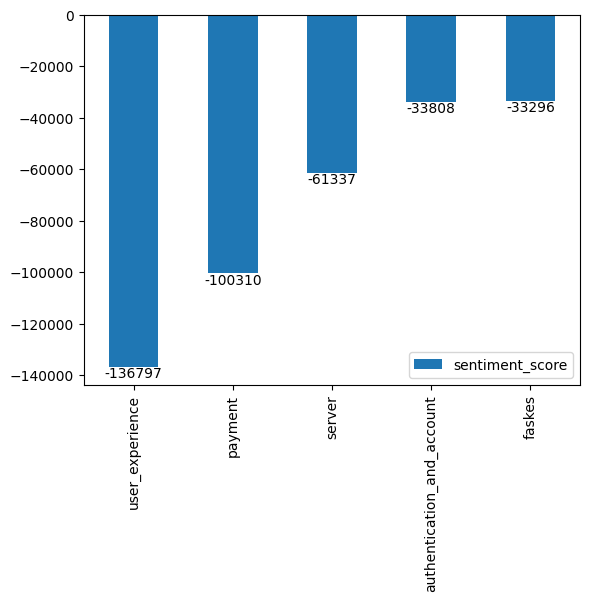

In [130]:
ax = sentiment_df.sort_values('sentiment_score').plot.bar()
ax.bar_label((ax.containers[0]))

plt.show()

In [12]:
model_docs_lbl_similarities.to_csv('model_docs_lbl_similarities.csv', index=False)

In [67]:
model_docs_lbl_similarities[['most_similar_label', 'content']].to_csv('content_label_comparison.csv', index=False)

In [137]:
Lbl2Vec_model.save('Lbl2Vec_model')

In [3]:
Lbl2Vec_model = Lbl2Vec.load('Lbl2Vec_model')

In [ ]:
Lbl2Vec_model.doc2vec_model.dv.vectors

In [11]:
model_docs_lbl_similarities = pd.read_csv('model_docs_lbl_similarities.csv')
model_docs_lbl_similarities.head()

,doc_key,most_similar_label,highest_similarity_score,user_experience,server,payment,authentication_and_account,faskes,userName,score,at,content,Cleaning,HapusEmoji,3/Lebih,CaseFolding,Formalisasi,sentiment_score,tagged_docs
0,0,authentication_and_account,0.397597,-0.228221,-0.040829,-0.284972,0.397597,-0.239553,Setiawan Jodi,1,2022-10-03 05:19:36,Saat login kode capchta tidak muncul jaringan ...,Saat login kode capchta tidak muncul jaringan ...,Saat login kode capchta tidak muncul jaringan ...,Saat login kode capchta tidak muncul jaringan ...,saat login kode capchta tidak muncul jaringan ...,saat login kode capchta tidak muncul jaringan ...,-23,"TaggedDocument<['saat', 'login', 'kode', 'capc..."
1,1,authentication_and_account,0.400477,-0.171505,-0.275439,-0.224857,0.400477,0.163774,Sri Astuti,1,2022-09-27 04:34:32,"Aplikasi yg gak jelas, hal yg mudah dibuat jd ...",Aplikasi yg gak jelas hal yg mudah dibuat jd ...,Aplikasi yg gak jelas hal yg mudah dibuat jd ...,Aplikasi yg gak jelas hal yg mudah dibuat jd ...,aplikasi yg gak jelas hal yg mudah dibuat jd ...,aplikasi yang gak jelas hal yang mudah dibuat ...,0,"TaggedDocument<['aplikasi', 'yang', 'gak', 'je..."
2,2,authentication_and_account,0.236454,0.100648,0.110374,-0.173836,0.236454,-0.059742,Pratiwi R,2,2022-10-03 07:16:04,Aplikasi nya kurang bagus versi sekarang... Ma...,Aplikasi nya kurang bagus versi sekarang Ma...,Aplikasi nya kurang bagus versi sekarang Ma...,Aplikasi nya kurang bagus versi sekarang Mau l...,aplikasi nya kurang bagus versi sekarang mau l...,aplikasi nya kurang bagus versi sekarang mau l...,-10,"TaggedDocument<['aplikasi', 'nya', 'kurang', '..."
3,3,faskes,0.290748,-0.167004,-0.280194,0.102101,-0.054915,0.290748,adnan maulana,5,2022-10-03 00:47:33,"Kekurangannya, tidak seluruh Bank tersedia unt...",Kekurangannya tidak seluruh Bank tersedia unt...,Kekurangannya tidak seluruh Bank tersedia unt...,Kekurangannya tidak seluruh Bank tersedia unt...,kekurangannya tidak seluruh bank tersedia unt...,kekurangannya tidak seluruh bank tersedia untu...,12,"TaggedDocument<['kekurangannya', 'tidak', 'sel..."
4,4,server,0.253248,0.077883,0.253248,0.240120,-0.076451,-0.140412,Indria Mandala Putri,1,2022-10-03 09:50:28,Di satu sisi aplikasi ini bagus dan memudahkan...,Di satu sisi aplikasi ini bagus dan memudahkan...,Di satu sisi aplikasi ini bagus dan memudahkan...,Di satu sisi aplikasi ini bagus dan memudahkan...,di satu sisi aplikasi ini bagus dan memudahkan...,di satu sisi aplikasi ini bagus dan memudahkan...,-17,"TaggedDocument<['di', 'satu', 'sisi', 'aplikas..."


In [131]:
lbl2vec_silhouette_score = silhouette_score(Lbl2Vec_model.doc2vec_model.dv.vectors, model_docs_lbl_similarities.most_similar_label)
lbl2vec_calinski_harabasz_score = calinski_harabasz_score(Lbl2Vec_model.doc2vec_model.dv.vectors, model_docs_lbl_similarities.most_similar_label)
lbl2vec_davies_bouldin_score = davies_bouldin_score(Lbl2Vec_model.doc2vec_model.dv.vectors, model_docs_lbl_similarities.most_similar_label)

In [139]:
lbl2vec_silhouette_score

0.015476633

In [133]:
lbl2vec_calinski_harabasz_score

2784.215782046256

In [134]:
lbl2vec_davies_bouldin_score

5.288807317006151

In [21]:
lbl2vec_davies_bouldin_score

4.662145567091938

In [18]:
lbl2vec_calinski_harabasz_score

2857.417641914363

In [17]:
lbl2vec_silhouette_score

0.0997697